In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/焦煤上游总库存.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['焦煤上游总库存'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()


,焦煤上游总库存,焦煤港口库存,焦煤煤矿库存/523家样本矿山,焦煤288口岸监管区总库存
2025-11-17,NaN,NaN,NaN,NaN
2025-11-18,NaN,NaN,NaN,NaN
2025-11-19,NaN,NaN,NaN,NaN
2025-11-20,NaN,NaN,NaN,NaN
2025-11-21,NaN,NaN,NaN,NaN


In [5]:
sheet.loc[:last_day, '焦煤上游总库存'] = sheet.loc[:last_day, '焦煤上游总库存'].interpolate(method='linear')


In [6]:
file_path1 = os.path.expanduser("eta/焦煤288口岸监管区总库存_合并数据.xlsx") 
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.drop(columns=['真实值'])
sheet1 = sheet1.dropna()

sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1.tail()

,Date,预测值
4,2025-11-03,211.0
3,2025-11-04,211.0
2,2025-11-05,211.0
1,2025-11-06,211.0
0,2025-11-07,211.0


In [7]:
file_path2 = os.path.expanduser("eta/焦煤港口库存_合并数据.xlsx") 
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet2['Date'] = pd.to_datetime(sheet2['Date'], errors='coerce')
sheet2 = sheet2.drop(columns=['真实值'])
sheet2 = sheet2.dropna()

sheet2 = sheet2.sort_values('Date', ascending=True)
sheet2.head()

,Date,预测值
19,2025-10-27,292.9
18,2025-10-28,298.1
17,2025-10-29,301.4
16,2025-10-30,300.5
15,2025-10-31,300.7


In [8]:
file_path3 = os.path.expanduser("eta/焦煤煤矿库存_合并数据.xlsx") 
sheet3 = pd.ExcelFile(file_path3).parse('Sheet1')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet3 = sheet3.drop(columns=['真实值'])
sheet3 = sheet3.dropna()

sheet3 = sheet3.sort_values('Date', ascending=True)
sheet3.head()

,Date,预测值
19,2025-10-27,366.8
18,2025-10-28,363.0
17,2025-10-29,366.8
16,2025-10-30,368.1
15,2025-10-31,357.5


In [9]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['焦煤288口岸监管区总库存'] = sheet_daily['焦煤288口岸监管区总库存'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 合并 sheet2 的美元指数数据 
sheet_daily = pd.merge(
    sheet_daily,
    sheet2[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['焦煤港口库存'] = sheet_daily['焦煤港口库存'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# sheet 3
sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['焦煤煤矿库存/523家样本矿山'] = sheet_daily['焦煤煤矿库存/523家样本矿山'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-06-01')]
sheet_daily.tail(10)

,Date,焦煤上游总库存,焦煤港口库存,焦煤煤矿库存/523家样本矿山,焦煤288口岸监管区总库存
966,2025-11-10,NaN,319.8,369.3,NaN
967,2025-11-11,NaN,322.2,369.9,NaN
968,2025-11-12,NaN,320.2,361.2,NaN
969,2025-11-13,NaN,318.9,363.0,NaN
970,2025-11-14,NaN,308.7,366.8,NaN
971,2025-11-17,NaN,311.6,392.2,NaN
972,2025-11-18,NaN,322.2,397.2,NaN
973,2025-11-19,NaN,320.7,411.2,NaN
974,2025-11-20,NaN,314.2,406.5,NaN
975,2025-11-21,NaN,309.3,397.5,NaN


In [10]:
# 添加新列 山东汽油裂解差_预测
sheet_daily['焦煤上游总库存_预测'] = sheet_daily['焦煤港口库存']  + sheet_daily['焦煤煤矿库存/523家样本矿山'] + sheet_daily['焦煤288口岸监管区总库存']
sheet_daily.tail()

,Date,焦煤上游总库存,焦煤港口库存,焦煤煤矿库存/523家样本矿山,焦煤288口岸监管区总库存,焦煤上游总库存_预测
971,2025-11-17,NaN,311.6,392.2,NaN,NaN
972,2025-11-18,NaN,322.2,397.2,NaN,NaN
973,2025-11-19,NaN,320.7,411.2,NaN,NaN
974,2025-11-20,NaN,314.2,406.5,NaN,NaN
975,2025-11-21,NaN,309.3,397.5,NaN,NaN


In [11]:
last_day = sheet_daily['Date'][sheet_daily['焦煤上游总库存'].last_valid_index()]

---

In [12]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '焦煤上游总库存']]
historical.columns = ['Date', '焦煤上游总库存']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', '焦煤上游总库存_预测']]
forecast.columns = ['Date', '焦煤上游总库存_预测']

# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/焦煤上游总库存_合并数据.xlsx', index=False,float_format='%.6f')
merged_df_daily.head()

,Date,焦煤上游总库存,焦煤上游总库存_预测
232,2025/11/21,NaN,NaN
231,2025/11/20,NaN,NaN
230,2025/11/19,NaN,NaN
229,2025/11/18,NaN,NaN
228,2025/11/17,NaN,NaN


In [13]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '焦煤上游总库存']]
historical_monthly.columns = ['Date', '焦煤上游总库存']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', '焦煤上游总库存_预测']]
forecast_monthly.columns = ['Date', '焦煤上游总库存_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/焦煤上游总库存_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly

,Date,焦煤上游总库存,焦煤上游总库存_预测
29,2025/11/30,NaN,879.140000
28,2025/10/31,872.523500,873.918000
27,2025/09/30,970.184500,NaN
26,2025/08/31,979.482000,974.490000
25,2025/07/31,1217.229500,1201.679500
24,2025/06/30,1460.173500,1428.098500
23,2025/05/31,1336.746800,1299.426800
22,2025/04/30,1282.507000,1255.082000
21,2025/03/31,1374.672500,1335.147500
20,2025/02/28,1438.665250,1397.002667


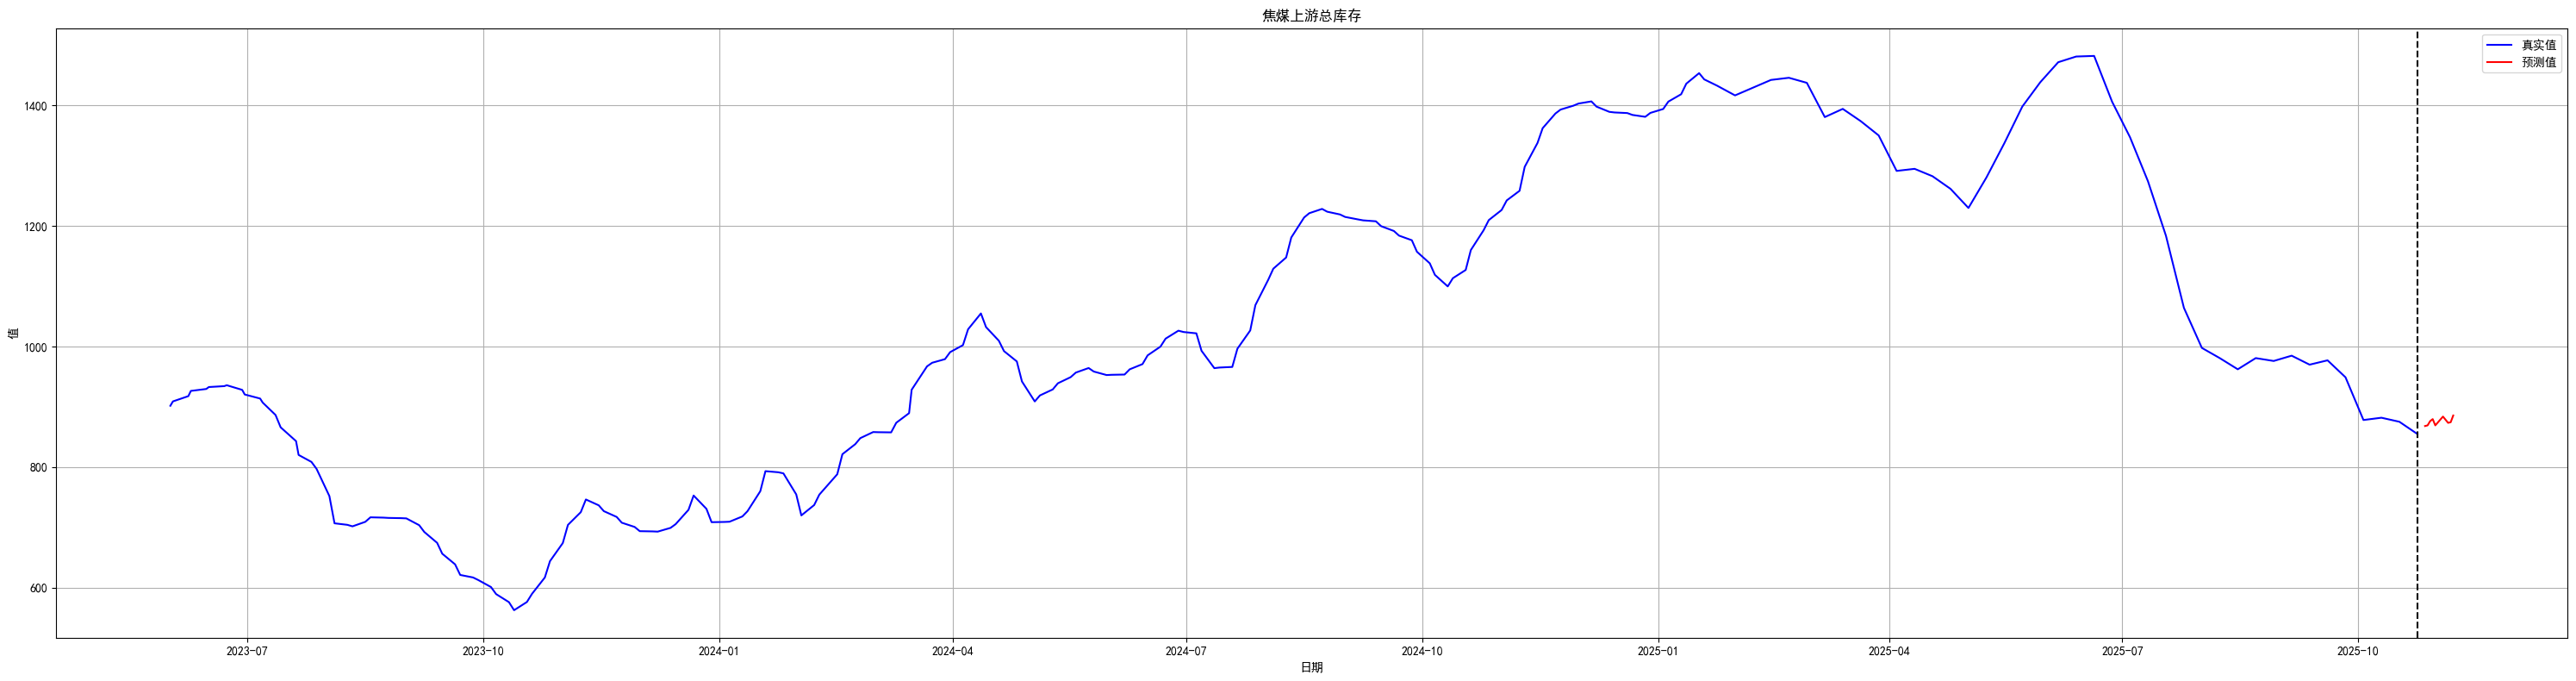

In [14]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_daily_plot = merged_df_daily.copy()
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['焦煤上游总库存'], color='blue', label='真实值')
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['焦煤上游总库存_预测'], color='red', label='预测值')

avline_date = pd.to_datetime(last_day)
plt.axvline(x=avline_date, color='black', linestyle='--')

# 设置图例
plt.legend()

# 设置标题和标签
plt.title('焦煤上游总库存')
plt.xlabel('日期')
plt.ylabel('值')
plt.grid(True)
plt.tight_layout()
plt.show()

---

In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.焦煤_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "焦煤上游总库存"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.焦煤_数据上传.xlsx"
sheet_name = "详情页"
identifier = "焦煤上游总库存"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列
已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
